# Performance énergétique des logements et niveau de vie des ménages en Ile-de-France¶

#### **Projet Python 2A ENSAE (année 2022-2023)**

#### Franki Nguimatsia Tiofak, Marc jodel Simo Noubissi, Gabriel Sklénard

## **Introduction**

### **Problématique:** 
 
Dans le contexte de la crise énergétique affectant un grand nombre de pays en 2022, il nous est apparu particulièrement intéressant d'étudier le lien entre performance énergétique des logements et niveau de vie des ménages. En effet, dans une période où la facture énergétique s'alourdit et atteint même des plus haut (en particulier pour le gaz), les ménages les plus défavorisés apparaissent plus vulnérables, et ce d'autant plus si leurs logements sont en moyenne plus énergivores que les ménages plus aisés. Notre projet Python cherche précisément à documenter cette vulnérabilité, avec notamment l'idée que la performance énergétique des logements ont un coût et bute nécessairement contre la contrainte budgétaire des ménages, mesurée ici par le niveau de vie médian au niveau de la commune. Qui plus est, un cercle vicieux pourrait s'instaurer: les ménages les moins aisés ont des difficultés à accéder à un logement économe en énergie, ce qui accroît la charge financière du logement et les appauvrit encore davantage. 

Pour avoir une volumétrie de données raisonnable, nous avons opté pour une approche géographique centrée sur l'Ile-de-France: il s'agit donc ici d'analyser la performance énergétique des logements franciliens en lien avec le niveau de vie mesuré dans chaque commune. La visualisation géographique pourrait contribuer à aider les décideurs publics à mieux cibler les éventuelles mesures de soutien à mettre en place pour atténuer le choc de la crise énergétique en Ile-de-France.

### **Principales étapes du projet:**
1. Récupération des données relatives aux diagnostics de performance énergétique (DPE) des logements franciliens (à partir de l'API de l'open data de l'ADEME.
2. Récupération des données de niveau de vie par commune à partir des fichiers de Filosofi 2016 disponibles sur Insee.fr
3. Retraitement des données.
4. Premières statistiques descriptives
5. Visualisations géographiques
6. Modélisation: quantification du rôle explicatif du niveau de vie médian de la commune sur: 
    a. la structure des logements par classe de consommation d'énergie; 
    b. le niveau moyen de consommation d'énergie par logement;
7. Principales limites et perspectives d'approfondissment

### **Principaux résultats et principales limites:**

#### Résulats de l'étude

1. Résultat 1: 
2. Résultat 2:
3. Résultat 3:

#### Limites de l'étude

1. Limite 1: les DPE observés dans chaque commune d'Ile-de-France ne résultent pas d'un échantillonage reposant sur un
plal de sondage garantissant la représentativité statistique des données à l'échelle de chaque commune. On ne dispose
en effet que d'une liste de DPE versés automatiquement dans la base de données de l'ADEME, dès lors qu'un diagnostic est validé numériquement. Par conséquent, on peut très bien imaginer que nos résultats sont affectés par des biais statistiques importants. Le nombre de DPE enregistrés dans une commune dépend du nombre de locations ou ventes de logements ayant eu lieu dans cette commune.
2. Limite 2:
3. Limite 3:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re
import matplotlib
import plotly.express as px
import seaborn as sns

import sklearn
from sklearn.linear_model import Lasso
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm
import scipy
from scipy.stats import chi2_contingency as chi2_contingency
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import plotly
import plotly.express as px
from IPython.display import HTML #pour afficher les graphs
# dans une cellule de notebook

In [3]:
# Pour que les graphiques apparaissent dans le Notebook Jupyter:
%matplotlib inline

## **Importation des données retraitées**

In [4]:
pd.options.display.max_colwidth = 50

On importe les données récupérées et traitées dans le notebook récup&retraitement_données.ipynb:

In [5]:
# 1) Dataframe rassemblant tous les dpe réalisés dans les communes d'Ile-de-France (principales caractéristiques relatives 
# à la performance énergétique des logements):
#dpe_idf = pd.read_csv("~/work/data_science_project/dpe_IDF.csv")

# 2) Dataframe rassemblant les communes d'IDF avec leur caractéristiques en terme de performance énergétique des logements
# ainsi que quelques données socio-économiques (Filosofi):
Filosofi_dpe_IDF_com= pd.read_csv("~/work/data_science_project/Filosofi_dpe_IDF_com.csv")

### ** Dictionnaire de variables pour le dataframe dpe_idf:**

- code_commune_actualise:
- 

## **I) Analyse exploratoire des données et datavisualisation**

### **A)Analyse de la performance énergétique des logements à l'échelle des communes d'Ile-de-France:**

#### 1) Etape préliminaire: on exclut de l'analyse les communes pour lesquelles le nombre de DPE s'avère trop faible au regard du nombre de ménages fiscaux renseignés dans Filosofi:

L'interprétabilité des résultats est conditionnée par le fait que l'on dispose d'un nombre suffisant de DPE dans chaque commune. Pour tester cette condition, on calcule le ratio "nombre de DPE/nombre de ménages fiscaux" pour chaqye commune, avec l'idée que le nombre de ménages fiscaux est un bon proxi du nombre total de logements dans une commune donnée.

In [6]:
# Calcul du ratio "nombre de DPE/nombre de ménages fiscaux":
Filosofi_dpe_IDF_com["ratio_DPE_menage"]=Filosofi_dpe_IDF_com["nombre_dpe"]/Filosofi_dpe_IDF_com["NBMENFISC16"]
Filosofi_dpe_IDF_com["ratio_DPE_menage"].describe()

count    1013.000000
mean        0.327655
std         0.686188
min         0.007556
25%         0.097826
50%         0.181564
75%         0.312899
max        11.027027
Name: ratio_DPE_menage, dtype: float64

Au vue de la distribution de ce ratio, on peut décider d'exclure les 25% des communes de l'analyse qui présentent un ratio inférieur à 10%:

In [7]:
Filosofi_dpe_IDF_com2=Filosofi_dpe_IDF_com[Filosofi_dpe_IDF_com["ratio_DPE_menage"]>0.1].reset_index()
Filosofi_dpe_IDF_com2.shape

(751, 53)

In [8]:
Filosofi_dpe_IDF_com.shape

(1288, 52)

#### 2) Premières statistiques descriptives sur la performance énergétique des logements dans les communes d'Ile-de-France

##### a) Création d'une indicatrice pour repérer les communes rassemblant le plus de logements énergivores

In [9]:
# Codage de l'indicatrice "est énergivore" (définition 2):
x=Filosofi_dpe_IDF_com2[["classe_consommation_energie_F","classe_consommation_energie_G"]]
x
x["proportion_energivores"]=x.sum(axis=1)
#FG=x[["proportion_energivores"]]
#Filosofi_dpe_IDF_com3=Filosofi_dpe_IDF_com2.merge(FG,left_index=True,right_index=True)
#Filosofi_dpe_IDF_com3.head()

/tmp/ipykernel_76706/1200650927.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 3) Quel lien statistique entre performance énergétique des logements d'une commune et le niveau de niveau médian des ménages qui y vivent?

## **II) Modélisation: prédiction de la structure des logements d'une commune en classes de consommation énergétique**

In [10]:
# Modèle logistique multinomial?
# Variable à expliquer: la structure des logements de la commune en termes de consommation énergétique
# Variables explicatives: le type de logement, la surface moyenne, l'ancienneté du logement, 
# le niveau de vie médian de la commune, milieur rural/milieu urbain, etc.



In [11]:
# On commence par faire une ACP

# Etape 0 : choix des variables
Filosofi_dpe_IDF_com1=Filosofi_dpe_IDF_com.dropna()
variable=['nombre_dpe','surface_thermique_lot_median','age_logement_median','NBPERSMENFISC16','classe_age_Neuf (<5ans)'
         ,'classe_age_Entre 50 et 100 ans','classe_age_Récent (entre 5 et 10 ans)','classe_age_Entre 10 et 25 ans',
          "classe_age_Entre 25 et 50 ans","classe_age_Plus de 100 ans","MED16","surface_thermique_lot_median"]

use_dpe=Filosofi_dpe_IDF_com1[variable]
use_dpe.head()

,nombre_dpe,surface_thermique_lot_median,age_logement_median,NBPERSMENFISC16,classe_age_Neuf (<5ans),classe_age_Entre 50 et 100 ans,classe_age_Récent (entre 5 et 10 ans),classe_age_Entre 10 et 25 ans,classe_age_Entre 25 et 50 ans,classe_age_Plus de 100 ans,MED16,surface_thermique_lot_median
0,7765.0,43.815,66.0,2074629.5,0.026272,0.709208,0.006825,0.033612,0.088088,0.135995,26808.000000,43.815
1,1308.0,47.705,68.0,15477.0,0.032875,0.583333,0.000765,0.019878,0.280581,0.082569,32697.333333,47.705
2,1124.0,41.215,65.0,20563.0,0.001779,0.451068,0.002669,0.008897,0.459964,0.075623,30566.500000,41.215
3,2179.0,45.510,67.0,32292.5,0.004589,0.510326,0.002295,0.026159,0.396971,0.059660,31333.000000,45.510
4,1464.0,49.035,67.0,25585.5,0.096995,0.476776,0.001366,0.002732,0.312842,0.109290,31007.222222,49.035


In [12]:
# Standardisation 
scaler = StandardScaler()
scaler.fit(use_dpe)

StandardScaler()

In [13]:
use_dpe.head()

,nombre_dpe,surface_thermique_lot_median,age_logement_median,NBPERSMENFISC16,classe_age_Neuf (<5ans),classe_age_Entre 50 et 100 ans,classe_age_Récent (entre 5 et 10 ans),classe_age_Entre 10 et 25 ans,classe_age_Entre 25 et 50 ans,classe_age_Plus de 100 ans,MED16,surface_thermique_lot_median
0,7765.0,43.815,66.0,2074629.5,0.026272,0.709208,0.006825,0.033612,0.088088,0.135995,26808.000000,43.815
1,1308.0,47.705,68.0,15477.0,0.032875,0.583333,0.000765,0.019878,0.280581,0.082569,32697.333333,47.705
2,1124.0,41.215,65.0,20563.0,0.001779,0.451068,0.002669,0.008897,0.459964,0.075623,30566.500000,41.215
3,2179.0,45.510,67.0,32292.5,0.004589,0.510326,0.002295,0.026159,0.396971,0.059660,31333.000000,45.510
4,1464.0,49.035,67.0,25585.5,0.096995,0.476776,0.001366,0.002732,0.312842,0.109290,31007.222222,49.035


In [14]:
sc_dpe =pd.DataFrame(data=scaler.transform(use_dpe),index=Filosofi_dpe_IDF_com1["CODGEO"],columns=variable)

Text(0, 0.5, 'Variance cumulative expliquée')

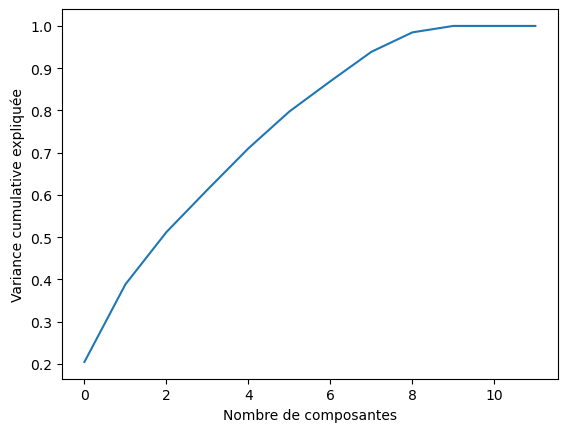

In [15]:
# Choix du nombre de composantes

pca = PCA().fit(sc_dpe)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulative expliquée')

### On choisit d'implémenter avec 5 composantes

In [16]:
pca=PCA(n_components=5)

In [17]:
pca.fit(sc_dpe)

PCA(n_components=5)

In [18]:
x_pca=pca.transform(sc_dpe)

In [19]:
x_pca.shape

(1013, 5)

In [20]:
# On choisir la couleur comme la proportion des logement énervore E,F et G
energivore=Filosofi_dpe_IDF_com1["classe_consommation_energie_G"]+Filosofi_dpe_IDF_com1["classe_consommation_energie_F"]+Filosofi_dpe_IDF_com1["classe_consommation_energie_E"]

In [21]:
result=pd.DataFrame(x_pca,columns=['PCA%i' % i for i in range(5)],index=use_dpe.index)
result["energivore"]=energivore
result["consommation_energie_median"]=Filosofi_dpe_IDF_com1["consommation_energie_median"]
result.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,energivore,consommation_energie_median
0,6.157288,-9.685762,12.930031,-1.557052,15.902193,0.577205,253.000
1,2.964931,-0.951794,0.515148,1.159110,-1.174694,0.493884,229.220
2,2.762346,-0.901952,-0.240209,0.041442,-1.031468,0.491103,229.505
3,2.901943,-1.139304,0.176697,0.362437,-0.589157,0.502524,233.120
4,2.583523,-0.962149,0.677957,0.644645,-1.233377,0.437842,207.360


In [22]:
for i in list(result.columns):
    result=result[(result[i]!= max(result[i]))]   
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002 entries, 1 to 1287
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PCA0                         1002 non-null   float64
 1   PCA1                         1002 non-null   float64
 2   PCA2                         1002 non-null   float64
 3   PCA3                         1002 non-null   float64
 4   PCA4                         1002 non-null   float64
 5   energivore                   1002 non-null   float64
 6   consommation_energie_median  1002 non-null   float64
dtypes: float64(7)
memory usage: 62.6 KB


In [23]:
#Plot initialisation
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=result["energivore"], cmap="Set2_r", s=30)

# make simple, bare axis lines through space:
#xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
#ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
#yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
#ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
#zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
#ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

# label the axes
#ax.set_xlabel("PC1")
#ax.set_ylabel("PC2")
#ax.set_zlabel("PC3")
#ax.set_title("PCA")
#plt.show()'''

In [24]:
# Provoir explicatif du model
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.20479555 0.18371703 0.12356039 0.10025104 0.09791528]
0.7102392971239245


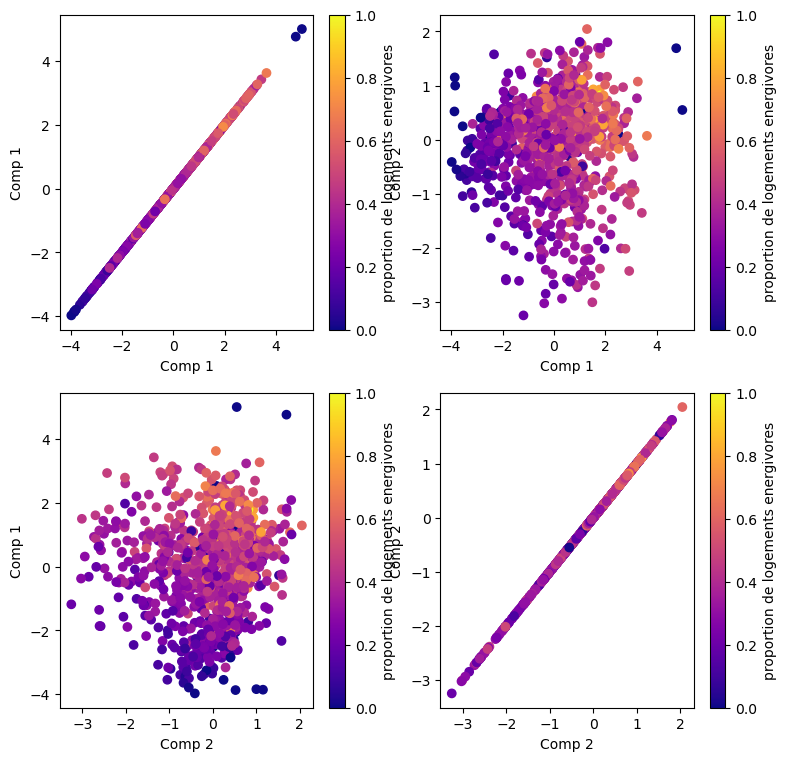

In [25]:
# Observation des ressembles sur les axes factorielles en fonction de la proportion
# de logements energivores

fig=plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.scatter(result["PCA0"],result["PCA0"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 1')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,2)
plt.scatter(result["PCA0"],result["PCA1"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 2')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,3)
plt.scatter(result["PCA1"],result["PCA0"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 1')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,4)
plt.scatter(result["PCA1"],result["PCA1"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 2')
plt.colorbar(label="proportion de logements energivores")

In [26]:
# Représentation dynamique en 3D  des axes factorielles en fonction de la proportion
# de logements energivores
#components = pca.fit_transform(sc_dpe)
var = pca.explained_variance_ratio_.sum() # variance expliquée
# Plot de la figure
fig = px.scatter_3d(data_frame=result[['PCA0','PCA1','PCA2']], x = 'PCA0', y='PCA1', z='PCA2',
                   color=result['energivore'],width=900,height=900)
fig.add_annotation()
fig.show()

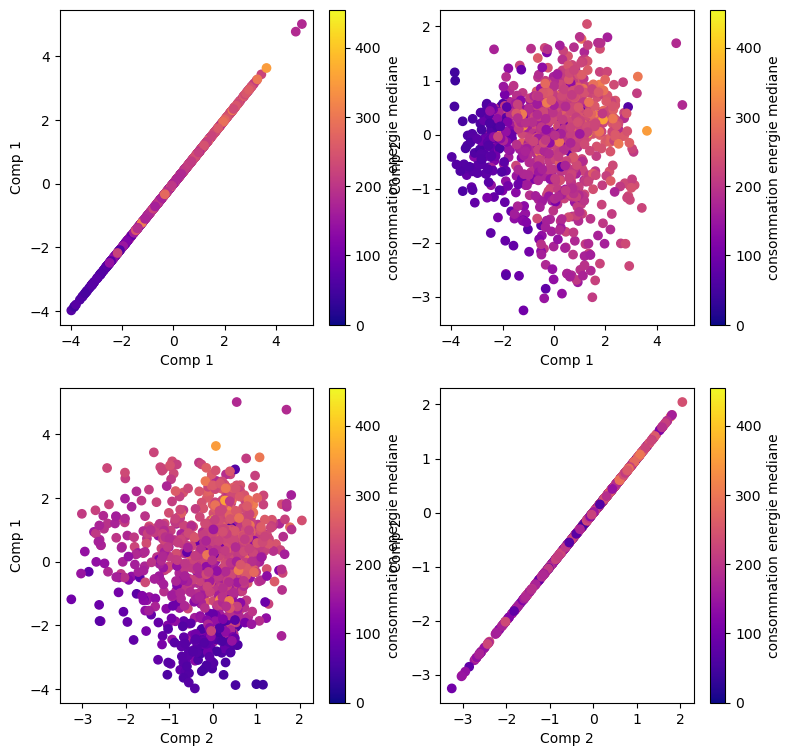

In [27]:

# Représentation dynamique en 3D  des axes factorielles en fonction de la consommation d'energie mediane dans
# led differentes communes

fig=plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.scatter(result["PCA0"],result["PCA0"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 1')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,2)
plt.scatter(result["PCA0"],result["PCA1"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 2')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,3)
plt.scatter(result["PCA1"],result["PCA0"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 1')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,4)
plt.scatter(result["PCA1"],result["PCA1"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 2')
plt.colorbar(label="consommation energie mediane")

In [28]:
# Représentation dynamique en 3D  des axes factorielles en fonction de le consommation d'energie median
var = pca.explained_variance_ratio_.sum() # variance expliquée
# Plot de la figure
fig = px.scatter_3d(data_frame=result[['PCA0','PCA1','PCA2']], x = 'PCA0', y='PCA1', z='PCA2',
                   color=result['consommation_energie_median'],width=900,height=900)
fig.add_annotation()
fig.show()

### Implémentation de la regression Lasso

In [29]:
# Variables potientielles
variable=['nombre_dpe','surface_thermique_lot_median','age_logement_median','NBPERSMENFISC16','classe_age_Neuf (<5ans)'
         ,'classe_age_Entre 50 et 100 ans','classe_age_Récent (entre 5 et 10 ans)','classe_age_Entre 10 et 25 ans',
          "classe_age_Entre 25 et 50 ans","MED16","surface_thermique_lot_median",
          "classe_surface_Moins de 30 m2","classe_surface_Entre 30 et 60 m2","classe_surface_Entre 60 et 100 m2",'classe_surface_Plus de 100 m2']

In [30]:
data=Filosofi_dpe_IDF_com1[variable]
y=Filosofi_dpe_IDF_com1['classe_consommation_energie_E']+Filosofi_dpe_IDF_com1['classe_consommation_energie_F']+Filosofi_dpe_IDF_com1['classe_consommation_energie_G']

In [31]:
# Echantillon d'apprentissage et echantillon de test 70% et 30% respectivement
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=10)

In [32]:
# Standartissation des variables pour éviter les effets de taille et d'échèlle
scaler = StandardScaler().fit(X_train[variable])
X_train[variable] = scaler.transform(X_train[variable])
X_test[variable] = scaler.transform(X_test[variable])

## choix du alpha optimal

In [33]:
# Lasso with 20 fold cross-validation
model = LassoCV(cv=20, random_state=0, max_iter=10000)

In [34]:
# Fit model
model.fit(X_train, y_train)

LassoCV(cv=20, max_iter=10000, random_state=0)

In [35]:
LassoCV(cv=20, max_iter=10000, random_state=0)

LassoCV(cv=20, max_iter=10000, random_state=0)

In [36]:
model.alpha_

0.003886429547813475

In [37]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.003886429547813475)

In [38]:
Lasso(alpha=model.alpha_)

Lasso(alpha=0.003886429547813475)

In [39]:
#Show model coefficients and names:

print(list(zip(lasso_best.coef_, data)))

[(-0.029879940260094363, 'nombre_dpe'), (-0.002533966910000469, 'surface_thermique_lot_median'), (-0.0013856029513043314, 'age_logement_median'), (0.0010874825879789501, 'NBPERSMENFISC16'), (-0.06943278416929274, 'classe_age_Neuf (<5ans)'), (0.03384741900541682, 'classe_age_Entre 50 et 100 ans'), (-0.0, 'classe_age_Récent (entre 5 et 10 ans)'), (0.0014418776475795887, 'classe_age_Entre 10 et 25 ans'), (0.026435560569143996, 'classe_age_Entre 25 et 50 ans'), (0.0, 'MED16'), (-0.0009174374350973801, 'surface_thermique_lot_median'), (0.003644327330470134, 'classe_surface_Moins de 30 m2'), (0.0, 'classe_surface_Entre 30 et 60 m2'), (0.0, 'classe_surface_Entre 60 et 100 m2'), (-0.0, 'classe_surface_Plus de 100 m2')]


In [40]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 46.64
R squared test set 56.19


In [41]:
mean_squared_error(y_test, lasso_best.predict(X_test))

0.01217499022908874

(7.307910561759445e-05,
 0.1458119854504169,
 0.0036247952212548613,
 0.05611515428782952)

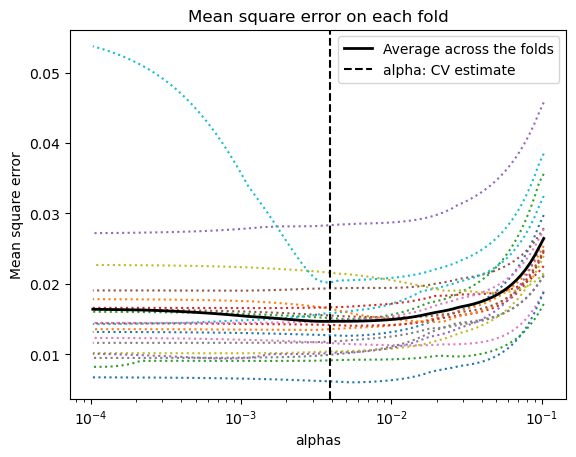

In [42]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

In [ ]:
## On reprend le meme model mais en u

In [43]:
data=Filosofi_dpe_IDF_com1[variable]
y=Filosofi_dpe_IDF_com1['consommation_energie_median']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=10)

In [45]:
scaler = StandardScaler().fit(X_train[variable])
X_train[variable] = scaler.transform(X_train[variable])
X_test[variable] = scaler.transform(X_test[variable])

In [46]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=20, random_state=0, max_iter=10000)

In [47]:
# Fit model
model.fit(X_train, y_train)

LassoCV(cv=20, max_iter=10000, random_state=0)

In [48]:
LassoCV(cv=20, max_iter=10000, random_state=0)

LassoCV(cv=20, max_iter=10000, random_state=0)

In [49]:
model.alpha_

2.170114397266668

In [50]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=2.170114397266668)

In [51]:
Lasso(alpha=model.alpha_)

Lasso(alpha=2.170114397266668)

In [52]:
#Show model coefficients and names:

print(list(zip(lasso_best.coef_, data)))

[(-5.565160059629397, 'nombre_dpe'), (-0.0, 'surface_thermique_lot_median'), (0.0, 'age_logement_median'), (0.0, 'NBPERSMENFISC16'), (-46.114809497358436, 'classe_age_Neuf (<5ans)'), (2.2444962342716304, 'classe_age_Entre 50 et 100 ans'), (0.0, 'classe_age_Récent (entre 5 et 10 ans)'), (0.0, 'classe_age_Entre 10 et 25 ans'), (1.2171820697290494, 'classe_age_Entre 25 et 50 ans'), (-0.0, 'MED16'), (-0.0, 'surface_thermique_lot_median'), (0.0, 'classe_surface_Moins de 30 m2'), (-0.0, 'classe_surface_Entre 30 et 60 m2'), (-0.0, 'classe_surface_Entre 60 et 100 m2'), (0.0, 'classe_surface_Plus de 100 m2')]


In [53]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 64.82
R squared test set 64.51


In [54]:
mean_squared_error(y_test, lasso_best.predict(X_test))

1523.6974167454234

(0.035491061747620144, 70.81397802326006, 523.0680963319396, 6858.391608774693)

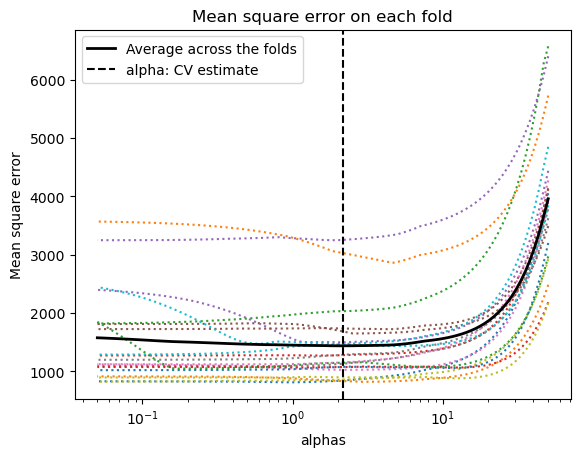

In [55]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")